<a href="https://colab.research.google.com/github/17092003vamsi/213ECE3317/blob/main/shap_trail_2_fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6066 - loss: 0.9194 - val_accuracy: 0.5161 - val_loss: 18.8737 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9120 - loss: 0.2952 - val_accuracy: 0.5161 - val_loss: 9.8401 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 849ms/step - accuracy: 0.9448 - loss: 0.2003 - val_accuracy: 0.5161 - val_loss: 6.8702 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9519 - loss: 0.1421 - val_accuracy: 0.5161 - val_loss: 4.3600 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 827ms/step - accuracy: 0.9914 - loss: 0.1017 - val_accuracy: 0.5161 - val_loss: 3.2790 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9714 - loss: 0.0891 - val_accuracy: 0.5161 - val_loss: 2.5911 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 920ms/step - accuracy: 0.9925 - loss: 0.0714 - val_accuracy: 0.5161 - 

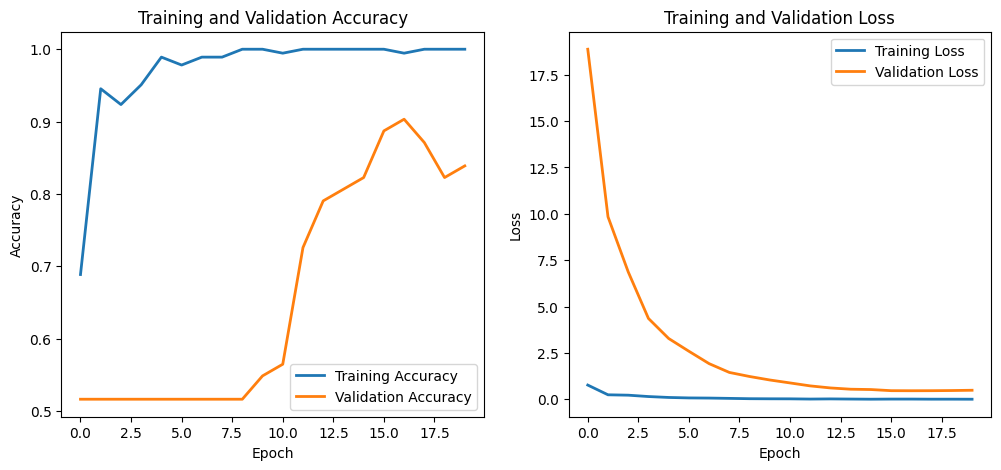

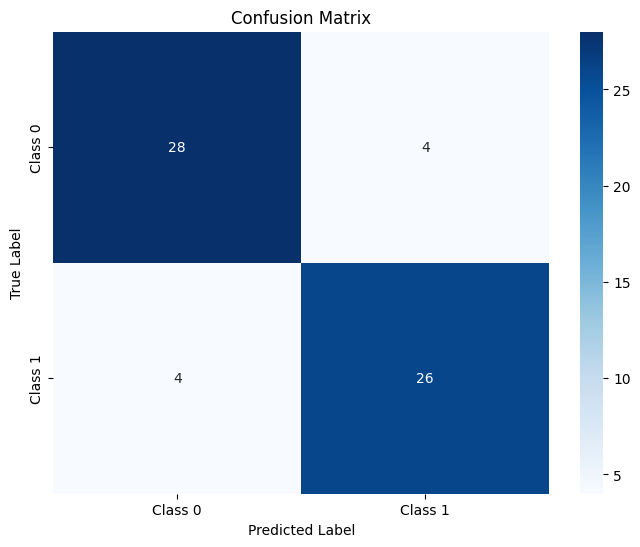

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


TypeError: only length-1 arrays can be converted to Python scalars

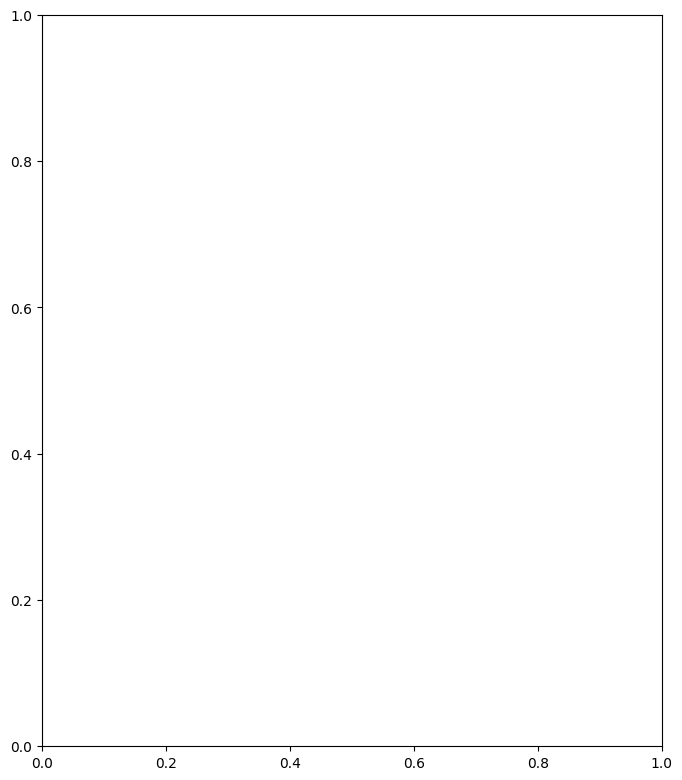

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
!pip install shap
import shap

# Load the dataset
def load_data(file_path):
    data = pd.read_csv('/content/COMPLETE DATA SET 2 (1).csv')
    return data

# Preprocess the data
def preprocess_data(data):
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data.iloc[:, -1].values)

    # Identify non-numeric columns and apply one-hot encoding
    X = data.iloc[:, :-1]
    non_numeric_cols = X.select_dtypes(exclude=['number']).columns
    X = pd.get_dummies(X, columns=non_numeric_cols)

    # Apply FFT to each signal in the feature matrix
    X = X.values
    X_fft = np.abs(np.array([fft(signal) for signal in X]))

    # Reshape the feature matrix for CNN input
    X_fft = X_fft.reshape((X_fft.shape[0], X_fft.shape[1], 1))

    return X_fft, y

# Split the dataset into training, validation, and testing sets
def split_data(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Build the CNN model
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the model with early stopping and learning rate reduction
def train_model(model, X_train, y_train, X_val, y_val):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Generate predictions and confusion matrix
    y_pred = (model.predict(X_test) > 0.5).astype("int64")
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return cm

# Visualize results (training accuracy, loss, and confusion matrix)
def plot_results(history, cm):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)  # Ensure linewidth is scalar
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


# SHAP explainability function
def explain_model(model, X_test):
    subset_size = 100
    X_test_subset = X_test[:subset_size]

    # Create SHAP Deep Explainer
    explainer = shap.DeepExplainer(model, X_test_subset)
    shap_values = explainer.shap_values(X_test_subset)

    # If shap_values is a list (for multi-output models), take the first element
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # Reshape SHAP values to match the original input shape for SHAP plots
    shap.summary_plot(shap_values, X_test_subset.reshape(X_test_subset.shape[0], -1), plot_type="bar")

# Main function
def main():
    file_path = 'COMPLETE DATA SET 2 (1).csv'  # Dataset path
    data = load_data(file_path)
    X, y = preprocess_data(data)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Build, train, and evaluate the model
    model = build_model((X_train.shape[1], 1))
    history = train_model(model, X_train, y_train, X_val, y_val)

    cm = evaluate_model(model, X_test, y_test)
    plot_results(history, cm)

    # Explain model using SHAP
    explain_model(model, X_test)

# Run the main function
if __name__ == "__main__":
    main()
